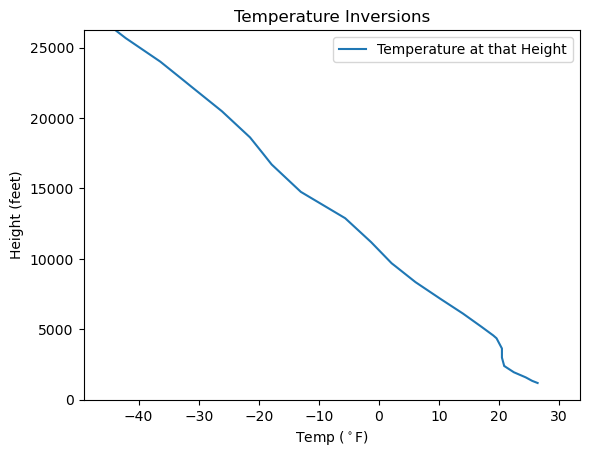

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import matplotlib.colors as mcolors
page = requests.get("https://rucsoundings.noaa.gov/get_soundings.cgi?start=latest&airport=72518&")
inputdata = BeautifulSoup(page.text, 'html')
data = inputdata.string[408:]
data = data.strip()
data = ' '.join(data.split())
data = data.replace(" ", ",")
rows = data.split(',')
df = pd.DataFrame([rows[i:i+7] for i in range(0, len(rows), 7)], columns=['TYPE', 'PRESSURE', 'HEIGHT', 'TEMP', 'DEWPT', 'WIND DIR', 'WIND SPD'])
df = df.apply(pd.to_numeric, errors='ignore')
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32
def tenthcelsius_to_celsius(tenthcelcius):
    return (tenthcelcius * 1/10)
def meters_to_feet(meters):
    return (meters * 3.28084)
df['TEMP_celsius'] = df['TEMP'].apply(tenthcelsius_to_celsius)
df['TEMP_fahrenheit'] = df['TEMP_celsius'].apply(celsius_to_fahrenheit)
df['HEIGHT_feet'] = df['HEIGHT'].apply(meters_to_feet)
boxpartition = [0,500,1000,2000,3000,4000,5000,6000,7000,8000]
flaglist = []
for i in range(len(boxpartition)-1):
    box = df[(df['HEIGHT'] >= boxpartition[i]) & (df['HEIGHT'] <= boxpartition[i+1])]['HEIGHT']
    boxmaxindex = box.idxmax()
    boxmax = box.max()
    boxtemp = df.loc[0:boxmaxindex, 'TEMP']
    boxtempmin = boxtemp.min()
    boxtempminindex = df.index[df['TEMP'] == boxtempmin].tolist()
    if boxmaxindex == boxtempminindex[0]:
        flaglist.append(0)
    else:
        flaglist.append(1)
df.plot(x='TEMP_fahrenheit', y='HEIGHT_feet', kind='line')
plt.xlabel(r'Temp ($^\circ$F)')
plt.ylabel('Height (feet)')
plt.title('Temperature Inversions')
plt.legend(['Temperature at that Height'])
plt.ylim(0,26246.72)
height_range = df[(df['HEIGHT'] >= 0 ) & (df['HEIGHT'] <= 10000)]['HEIGHT']
maxheightindex = box.idxmax()
temps = df.loc[0:maxheightindex, 'TEMP_fahrenheit']
tempmin = temps.min()
tempmax = temps.max()
plt.xlim(tempmin-7,tempmax+7)
colors = mcolors.LinearSegmentedColormap.from_list('red_to_yellow', ['red', 'yellow'])
for i in range(len(boxpartition)-1):
    flag = flaglist[i]
    boxbottom = boxpartition[i]* 3.28084
    boxtop = boxpartition[i+1]* 3.28084
    color_value = i / (len(boxpartition)-1)
    xmid = (tempmin+tempmax)/2
    ymid = (boxbottom+boxtop)/2
    if flag == 1:
        plt.fill_betweenx([boxbottom, boxtop], tempmin-7, tempmax+7, color=colors(color_value), alpha=0.3)
        plt.text(xmid-30, ymid-600, 'Inversion', fontsize=12, color='red', ha='center', va='bottom')
plt.show()